In [ ]:
import numpy as np
from xrd_simulator.beam import Beam
# X射线束被表示为一个凸多面体
# 我们在numpy数组中指定顶点坐标
# 这里定义了一个长方体形状的X射线束，长度为2e6单位，截面为1000×1000单位
beam_vertices = np.array([
    [-1e6, -500., -500.],  # 光束入射端的四个顶点
    [-1e6, 500., -500.],
    [-1e6, 500., 500.],
    [-1e6, -500., 500.],
    [1e6, -500., -500.],   # 光束出射端的四个顶点
    [1e6, 500., -500.],
    [1e6, 500., 500.],
    [1e6, -500., 500.]])

# 创建X射线束对象
beam = Beam(
    beam_vertices,
    xray_propagation_direction=np.array([1., 0., 0.]),  # X射线沿x轴正方向传播
    wavelength=0.28523,  # 设置X射线波长，单位为埃(Å)
    polarization_vector=np.array([0., 1., 0.]))  # 偏振方向沿y轴

from xrd_simulator.detector import Detector
# 探测器平面由三个角点坐标定义：det_corner_0, det_corner_1, det_corner_2
# 这些坐标确定了探测器的位置和方向
detector = Detector(pixel_size_z=75.0,  # z方向像素尺寸
                    pixel_size_y=55.0,  # y方向像素尺寸
                    det_corner_0=np.array([142938.3, -38400., -38400.]),  # 探测器左下角坐标
                    det_corner_1=np.array([142938.3, 38400., -38400.]),   # 探测器右下角坐标
                    det_corner_2=np.array([142938.3, -38400., 38400.]))   # 探测器左上角坐标
                    # 注意探测器位于x=142938.3平面上，大小为76800×76800单位

# 新的探测器距离
new_distance = 200000.0

detector = Detector(pixel_size_z=75.0,
                    pixel_size_y=55.0,
                    det_corner_0=np.array([new_distance, -38400., -38400.]),
                    det_corner_1=np.array([new_distance, 38400., -38400.]),
                    det_corner_2=np.array([new_distance, -38400., 38400.]))

print(f"新的探测器距离: {detector.det_corner_0[0]}")


from xrd_simulator.mesh import TetraMesh
# xrd_simulator支持多种网格生成方式
# 这里我们使用水平集(level set)方法生成一个实心球体的四面体网格
mesh = TetraMesh.generate_mesh_from_levelset(
    level_set=lambda x: np.linalg.norm(x) - 1768.0,  # 定义球体的水平集函数：||x||-768=0
    bounding_radius=1769.0,  # 边界半径略大于实际球体半径
    max_cell_circumradius=450.)  # 控制网格细度的参数

from xrd_simulator.phase import Phase
quartz = Phase(unit_cell=[4.926, 4.926, 5.4189, 90., 90., 120.],
               sgname='P3221',  # (Quartz)
               path_to_cif_file=None  # phases can be defined from crystalographic information files
               )

from scipy.spatial.transform import Rotation as R
from xrd_simulator.polycrystal import Polycrystal
# 创建随机晶粒取向的多晶体
orientation = R.random(mesh.number_of_elements).as_matrix()  # 为每个网格元素生成随机旋转矩阵
polycrystal = Polycrystal(mesh,
                          orientation,  # 每个晶粒的取向
                          strain=np.zeros((3, 3)),  # 应变张量，这里设为零（无应变）
                          phases=quartz,  # 使用前面定义的石英相
                          element_phase_map=None)  # 不指定元素相映射，默认所有元素都是同一相

# 保存多晶体模型，便于后续使用或可视化
polycrystal.save('my_polycrystal', save_mesh_as_xdmf=True)  # 保存为xdmf格式，可在ParaView等软件中查看


新的探测器距离: 200000.0


Rendering 44 scattering volumes unto the detector       |████████████████████████████████████████| 100.0%


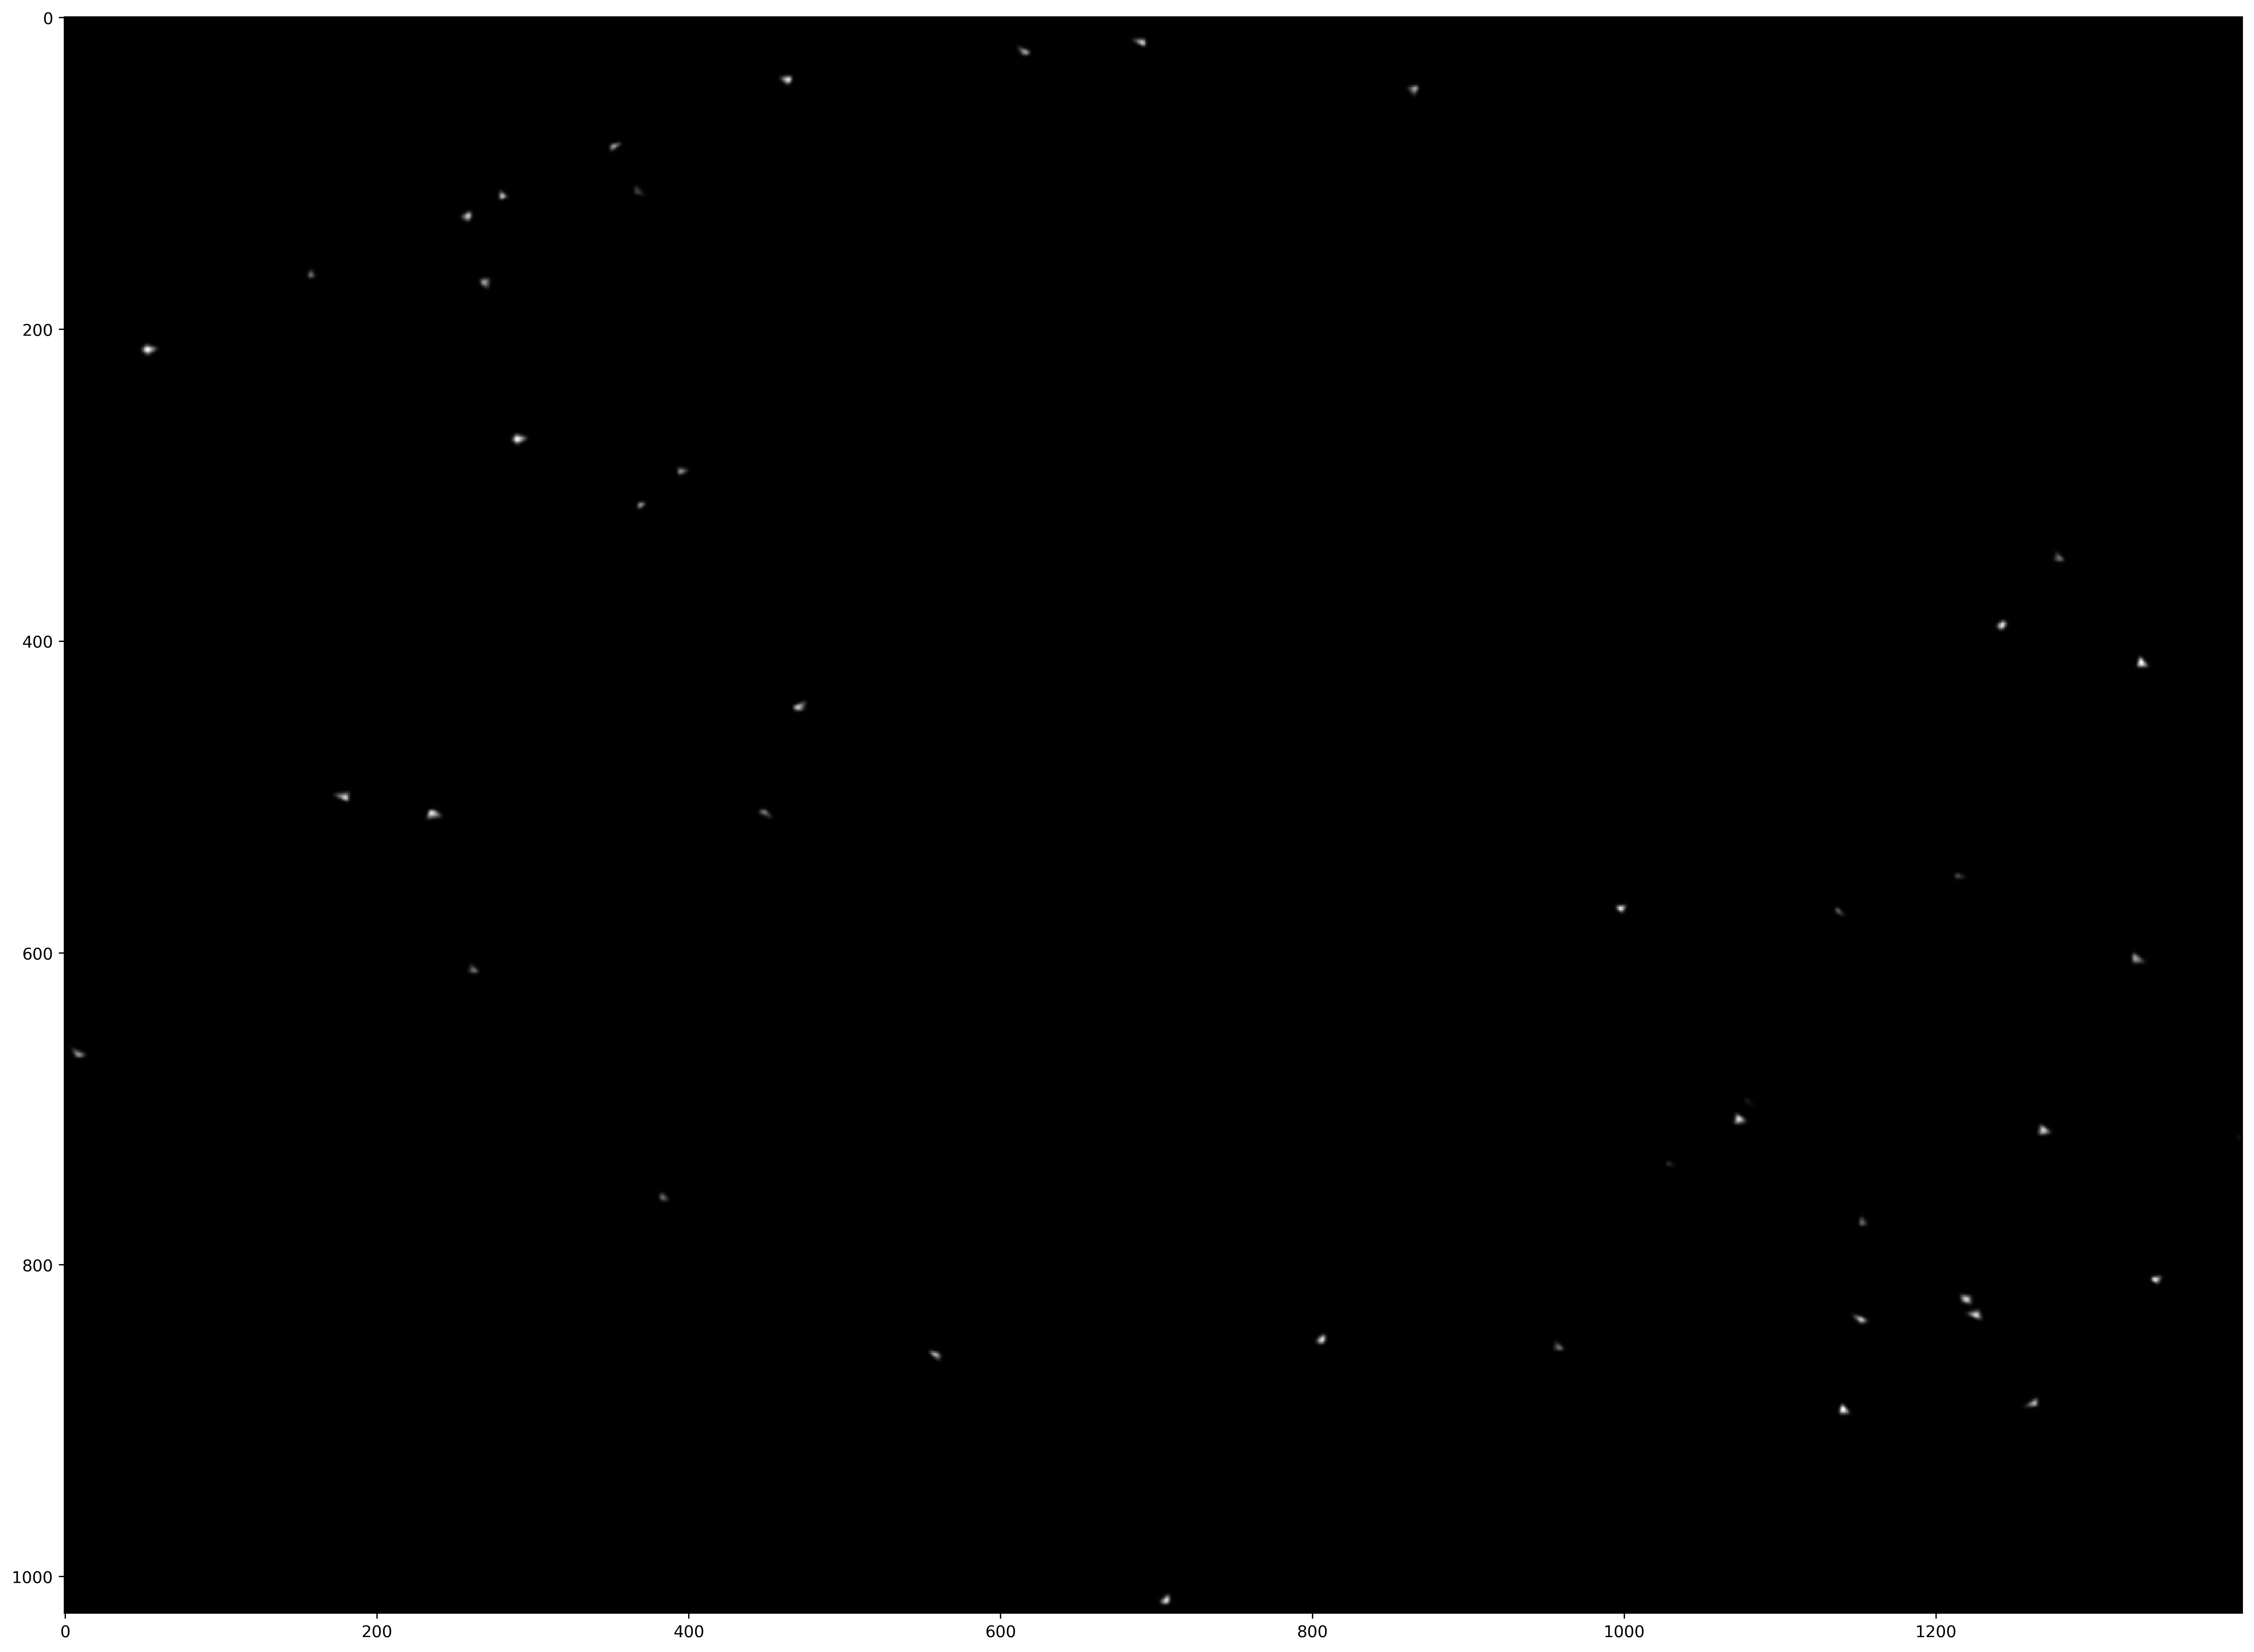

In [2]:
from xrd_simulator.motion import RigidBodyMotion
# 定义样品的刚体运动，模拟旋转样品的衍射过程
motion = RigidBodyMotion(rotation_axis=np.array([0, 1/np.sqrt(2), -1/np.sqrt(2)]),  # 旋转轴方向
                         rotation_angle=np.radians(1.0),  # 旋转角度(1度)
                         translation=np.array([123, -153.3, 3.42]))  # 平移向量

# 执行衍射模拟计算
polycrystal.diffract(beam, detector, motion)  # 计算多晶体在给定运动、光束和探测器条件下的衍射
# 渲染衍射图案
diffraction_pattern = detector.render(frames_to_render=0,  # 渲染第0帧
                                      lorentz=False,       # 不应用洛伦兹因子校正
                                      polarization=False,  # 不应用偏振因子校正
                                      structure_factor=False,  # 不应用结构因子校正
                                      method="project")    # 使用投影方法渲染

import matplotlib.pyplot as plt
# 设置更大的图片尺寸和更高的DPI以获得高质量图像
fig, ax = plt.subplots(1, 1, figsize=(24, 20), dpi=400)

# 显示衍射图案
ax.imshow(diffraction_pattern, cmap='gray', interpolation='nearest')
plt.savefig('diffraction_pattern.png')  # 保存衍射图案为PNG文件
plt.show()  # 显示衍射图案